In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.model import VSpyct
from src.utils import (calculate_bs, fix_predictions, plot_brier)
from src.data.dataset import SurvivalDataset

/Users/viktorandonovic/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
data = SurvivalDataset(fname='pbc.rda', path='../data/raw/')
X_train, X_test, y_train, y_test = data.get_tensors()

Succesfully created time tensor of shape: torch.Size([418, 4795])
(334, 769) torch.Size([334, 4795])


In [25]:
model = VSpyct(max_depth=3, bs=64)
model.fit(X_train, y_train)

Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 559655940505.6001


Epochs:   1%|▏         | 2/150 [00:00<00:10, 14.09it/s]

[iteration 0002] loss: 514152810905.6000


Epochs:   3%|▎         | 4/150 [00:00<00:09, 15.28it/s]

[iteration 0003] loss: 481029317017.6000
[iteration 0004] loss: 432263655219.2000
[iteration 0005] loss: 404794852352.0000


Epochs:   4%|▍         | 6/150 [00:00<00:09, 15.66it/s]

[iteration 0006] loss: 367298138112.0000


Epochs:   5%|▌         | 8/150 [00:00<00:08, 15.99it/s]

[iteration 0007] loss: 329963426304.0000
[iteration 0008] loss: 309151202508.8000
[iteration 0009] loss: 288007954431.9999


Epochs:   7%|▋         | 10/150 [00:00<00:08, 15.99it/s]

[iteration 0010] loss: 254345424998.4000


Epochs:   8%|▊         | 12/150 [00:00<00:08, 16.04it/s]

[iteration 0011] loss: 234992584089.6000
[iteration 0012] loss: 219886035507.2000
[iteration 0013] loss: 198048763596.8000


Epochs:   9%|▉         | 14/150 [00:00<00:08, 16.14it/s]

[iteration 0014] loss: 183066643968.0000


Epochs:  11%|█         | 16/150 [00:01<00:08, 16.34it/s]

[iteration 0015] loss: 171354081817.6000
[iteration 0016] loss: 161404618905.6000
[iteration 0017] loss: 150602963737.6000


Epochs:  12%|█▏        | 18/150 [00:01<00:08, 16.44it/s]

[iteration 0018] loss: 135656154380.8000


Epochs:  13%|█▎        | 20/150 [00:01<00:07, 16.55it/s]

[iteration 0019] loss: 126685476544.0000
[iteration 0020] loss: 115865756915.2000
[iteration 0021] loss: 110213558420.4875


Epochs:  15%|█▍        | 22/150 [00:01<00:07, 16.56it/s]

[iteration 0022] loss: 102199467329.5000


Epochs:  16%|█▌        | 24/150 [00:01<00:07, 16.65it/s]

[iteration 0023] loss: 95080594618.6875
[iteration 0024] loss: 95175956693.2000
[iteration 0025] loss: 86863313438.6000


Epochs:  17%|█▋        | 26/150 [00:01<00:07, 16.65it/s]

[iteration 0026] loss: 83835962967.5125


Epochs:  19%|█▊        | 28/150 [00:01<00:07, 16.73it/s]

[iteration 0027] loss: 77555830958.2828
[iteration 0028] loss: 73608741559.6000
[iteration 0029] loss: 71153142280.9000


Epochs:  20%|██        | 30/150 [00:01<00:07, 16.74it/s]

[iteration 0030] loss: 67917362892.8438


Epochs:  21%|██▏       | 32/150 [00:01<00:07, 16.73it/s]

[iteration 0031] loss: 64528735300.9836
[iteration 0032] loss: 63389862059.3094
[iteration 0033] loss: 63210783434.0000


Epochs:  23%|██▎       | 34/150 [00:02<00:06, 16.73it/s]

[iteration 0034] loss: 59211093495.1375


Epochs:  24%|██▍       | 36/150 [00:02<00:06, 16.78it/s]

[iteration 0035] loss: 59367318539.1678
[iteration 0036] loss: 56477566067.9000
[iteration 0037] loss: 55745454323.7438


Epochs:  25%|██▌       | 38/150 [00:02<00:06, 16.79it/s]

[iteration 0038] loss: 53894185734.3500


Epochs:  27%|██▋       | 40/150 [00:02<00:06, 16.82it/s]

[iteration 0039] loss: 53060955599.4953
[iteration 0040] loss: 51694075567.0000
[iteration 0041] loss: 49720369536.9313


Epochs:  28%|██▊       | 42/150 [00:02<00:06, 16.79it/s]

[iteration 0042] loss: 51234172378.2250


Epochs:  29%|██▉       | 44/150 [00:02<00:06, 16.85it/s]

[iteration 0043] loss: 50994459997.7297
[iteration 0044] loss: 47554600460.4115
[iteration 0045] loss: 50886808061.4500


Epochs:  31%|███       | 46/150 [00:02<00:06, 16.81it/s]

[iteration 0046] loss: 50295178659.3149


Epochs:  31%|███       | 46/150 [00:02<00:06, 16.14it/s]


Early stopping at epoch 46.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 213190543564.8000
[iteration 0002] loss: 212299524505.6000


Epochs:   3%|▎         | 4/150 [00:00<00:04, 33.53it/s]

[iteration 0003] loss: 201326383308.8000
[iteration 0004] loss: 191631853465.6000
[iteration 0005] loss: 185703650201.6000
[iteration 0006] loss: 184222472601.6000
[iteration 0007] loss: 168991661363.2000
[iteration 0008] loss: 163102171955.2000


Epochs:   5%|▌         | 8/150 [00:00<00:04, 34.23it/s]

[iteration 0009] loss: 160838712422.4000
[iteration 0010] loss: 149517614899.2000
[iteration 0011] loss: 145880221388.8000
[iteration 0012] loss: 142810948198.4000


Epochs:   8%|▊         | 12/150 [00:00<00:04, 34.50it/s]

[iteration 0013] loss: 139337703731.2000


Epochs:  11%|█         | 16/150 [00:00<00:03, 34.60it/s]

[iteration 0014] loss: 121186374656.0000
[iteration 0015] loss: 126404280524.8000
[iteration 0016] loss: 121599584768.0000
[iteration 0017] loss: 111314187673.6000


Epochs:  13%|█▎        | 20/150 [00:00<00:03, 34.75it/s]

[iteration 0018] loss: 113401968230.4000
[iteration 0019] loss: 104936153497.6000
[iteration 0020] loss: 99478521344.0000
[iteration 0021] loss: 100555817472.0000


Epochs:  16%|█▌        | 24/150 [00:00<00:03, 34.85it/s]

[iteration 0022] loss: 93468730675.2000
[iteration 0023] loss: 92518703513.6000
[iteration 0024] loss: 85858226176.0000
[iteration 0025] loss: 82483170201.6000


Epochs:  19%|█▊        | 28/150 [00:00<00:03, 34.79it/s]

[iteration 0026] loss: 81053101875.2000
[iteration 0027] loss: 77323198361.6000
[iteration 0028] loss: 77716211814.4000
[iteration 0029] loss: 75479696793.6000


Epochs:  21%|██▏       | 32/150 [00:00<00:03, 34.84it/s]

[iteration 0030] loss: 68603032883.2000
[iteration 0031] loss: 66802039500.8000
[iteration 0032] loss: 60757905612.8000
[iteration 0033] loss: 58935137177.6000


Epochs:  24%|██▍       | 36/150 [00:01<00:03, 34.84it/s]

[iteration 0034] loss: 58976246988.8000
[iteration 0035] loss: 52304629657.6000
[iteration 0036] loss: 51609791948.8000
[iteration 0037] loss: 50806500300.8000


Epochs:  27%|██▋       | 40/150 [00:01<00:03, 34.89it/s]

[iteration 0038] loss: 49900720230.4000
[iteration 0039] loss: 46616485990.4000
[iteration 0040] loss: 47012090624.0000
[iteration 0041] loss: 45210664601.6000


Epochs:  29%|██▉       | 44/150 [00:01<00:03, 34.89it/s]

[iteration 0042] loss: 43101875097.6000
[iteration 0043] loss: 39889114419.2000
[iteration 0044] loss: 40664119244.8000
[iteration 0045] loss: 36230943974.4000


Epochs:  32%|███▏      | 48/150 [00:01<00:02, 34.94it/s]

[iteration 0046] loss: 34617128473.6000
[iteration 0047] loss: 34708105139.2000
[iteration 0048] loss: 33102683545.6000
[iteration 0049] loss: 33107211852.8000
[iteration 0050] loss: 31063244083.2000
[iteration 0051] loss: 29893324953.6000
[iteration 0052] loss: 29135650630.4000


Epochs:  35%|███▍      | 52/150 [00:01<00:02, 34.78it/s]

[iteration 0053] loss: 30001527372.8000
[iteration 0054] loss: 27567767987.2000
[iteration 0055] loss: 26927612000.0000


Epochs:  37%|███▋      | 56/150 [00:01<00:02, 34.70it/s]

[iteration 0056] loss: 25489819929.6000


Epochs:  40%|████      | 60/150 [00:01<00:02, 34.63it/s]

[iteration 0057] loss: 24337401382.4000
[iteration 0058] loss: 25025113606.4000
[iteration 0059] loss: 23932307692.8000
[iteration 0060] loss: 23307283564.8000
[iteration 0061] loss: 22651127532.8000
[iteration 0062] loss: 21554314464.0000
[iteration 0063] loss: 21517280819.2000


Epochs:  45%|████▌     | 68/150 [00:01<00:02, 34.66it/s]

[iteration 0064] loss: 21226839206.4000
[iteration 0065] loss: 19291281870.4000
[iteration 0066] loss: 18869534704.0000
[iteration 0067] loss: 17857772640.0000
[iteration 0068] loss: 18083019053.0000
[iteration 0069] loss: 17871173529.2000
[iteration 0070] loss: 15678153613.6000
[iteration 0071] loss: 16819703291.6000


Epochs:  48%|████▊     | 72/150 [00:02<00:02, 34.19it/s]


[iteration 0072] loss: 15737378309.2000
Early stopping at epoch 72.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 223550698700.8000
[iteration 0002] loss: 218669371596.8000
[iteration 0003] loss: 207773090611.2000
[iteration 0004] loss: 213457650073.6000


Epochs:   3%|▎         | 5/150 [00:00<00:03, 44.56it/s]


[iteration 0005] loss: 210259384524.8000
Early stopping at epoch 5.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 19222824448.0000
[iteration 0002] loss: 17179687628.8000
[iteration 0003] loss: 14672329420.8000
[iteration 0004] loss: 15847473664.0000


Epochs:   7%|▋         | 10/150 [00:00<00:01, 96.85it/s]

[iteration 0005] loss: 14843804467.2000
[iteration 0006] loss: 14262117068.8000
[iteration 0007] loss: 14556045926.4000
[iteration 0008] loss: 14633042227.2000
[iteration 0009] loss: 11625677670.4000
[iteration 0010] loss: 12878479513.6000
[iteration 0011] loss: 11363158835.2000
[iteration 0012] loss: 11769643008.0000
[iteration 0013] loss: 11259049523.2000
[iteration 0014] loss: 9972098150.4000
[iteration 0015] loss: 10455952896.0000
[iteration 0016] loss: 9619559680.0000
[iteration 0017] loss: 10151043328.0000


Epochs:  14%|█▍        | 21/150 [00:00<00:01, 99.37it/s]

[iteration 0018] loss: 8042775091.2000
[iteration 0019] loss: 6975824435.2000
[iteration 0020] loss: 9483725312.0000
[iteration 0021] loss: 6788569395.2000
[iteration 0022] loss: 7839465420.8000
[iteration 0023] loss: 6765097420.8000
[iteration 0024] loss: 7817239808.0000
[iteration 0025] loss: 7157940019.2000


Epochs:  17%|█▋        | 25/150 [00:00<00:01, 94.71it/s]


Early stopping at epoch 25.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 276090535731.2000
[iteration 0002] loss: 256991272960.0000


Epochs:   2%|▏         | 3/150 [00:00<00:05, 24.97it/s]

[iteration 0003] loss: 243819143782.4000
[iteration 0004] loss: 233784668160.0000


Epochs:   4%|▍         | 6/150 [00:00<00:05, 25.19it/s]

[iteration 0005] loss: 219578949836.8000
[iteration 0006] loss: 208481825587.2000
[iteration 0007] loss: 193781403443.2000
[iteration 0008] loss: 180700733440.0000


Epochs:   6%|▌         | 9/150 [00:00<00:05, 25.20it/s]

[iteration 0009] loss: 173001199104.0000
[iteration 0010] loss: 163860176332.8000


Epochs:   8%|▊         | 12/150 [00:00<00:05, 25.33it/s]

[iteration 0011] loss: 151211076403.2000
[iteration 0012] loss: 143959668531.2000
[iteration 0013] loss: 135392891136.0000
[iteration 0014] loss: 131117612160.0000


Epochs:  10%|█         | 15/150 [00:00<00:05, 25.38it/s]

[iteration 0015] loss: 123336240000.0000
[iteration 0016] loss: 114450193836.8000


Epochs:  12%|█▏        | 18/150 [00:00<00:05, 25.40it/s]

[iteration 0017] loss: 111047903257.6000
[iteration 0018] loss: 106640329254.4000
[iteration 0019] loss: 99108732736.0000
[iteration 0020] loss: 97132986912.0000


Epochs:  14%|█▍        | 21/150 [00:00<00:05, 25.40it/s]

[iteration 0021] loss: 88744516070.4000
[iteration 0022] loss: 87015547222.4000


Epochs:  16%|█▌        | 24/150 [00:00<00:04, 25.43it/s]

[iteration 0023] loss: 83784102371.2000
[iteration 0024] loss: 81296372789.2176
[iteration 0025] loss: 77918940018.2500
[iteration 0026] loss: 73391458578.1000


Epochs:  18%|█▊        | 27/150 [00:01<00:04, 25.40it/s]

[iteration 0027] loss: 72322505653.1000
[iteration 0028] loss: 67702121248.8125


Epochs:  20%|██        | 30/150 [00:01<00:04, 25.45it/s]

[iteration 0029] loss: 66299137302.2000
[iteration 0030] loss: 66025977650.0981
[iteration 0031] loss: 60455769297.6144
[iteration 0032] loss: 62179292724.1875


Epochs:  22%|██▏       | 33/150 [00:01<00:04, 25.37it/s]

[iteration 0033] loss: 58160340854.6000
[iteration 0034] loss: 58270021050.4000


Epochs:  24%|██▍       | 36/150 [00:01<00:04, 25.39it/s]

[iteration 0035] loss: 56886256575.8000
[iteration 0036] loss: 55124166163.9000
[iteration 0037] loss: 54255719498.2000
[iteration 0038] loss: 52991807930.6922


Epochs:  26%|██▌       | 39/150 [00:01<00:04, 25.32it/s]

[iteration 0039] loss: 52078148081.0000
[iteration 0040] loss: 51334478794.1812


Epochs:  28%|██▊       | 42/150 [00:01<00:04, 25.42it/s]

[iteration 0041] loss: 50402194257.9333
[iteration 0042] loss: 50555669871.0867
[iteration 0043] loss: 48857297896.2125
[iteration 0044] loss: 47505685048.5152


Epochs:  30%|███       | 45/150 [00:01<00:04, 25.41it/s]

[iteration 0045] loss: 48170032552.8406
[iteration 0046] loss: 46718075031.0481


Epochs:  32%|███▏      | 48/150 [00:01<00:04, 25.45it/s]

[iteration 0047] loss: 45973978320.5500
[iteration 0048] loss: 44906083925.3820
[iteration 0049] loss: 44412151162.0219
[iteration 0050] loss: 45220168033.6000


Epochs:  34%|███▍      | 51/150 [00:02<00:03, 25.37it/s]

[iteration 0051] loss: 45570042803.1469


Epochs:  34%|███▍      | 51/150 [00:02<00:03, 24.87it/s]

Early stopping at epoch 51.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 135116740198.4000
[iteration 0002] loss: 131838198579.2000
[iteration 0003] loss: 130507587584.0000
[iteration 0004] loss: 132409045811.2000
[iteration 0005] loss: 130553428377.6000
[iteration 0006] loss: 127348500889.6000
[iteration 0007] loss: 126930242764.8000


Epochs:   7%|▋         | 11/150 [00:00<00:01, 101.89it/s]

[iteration 0008] loss: 129182678220.8000
[iteration 0009] loss: 124823998464.0000
[iteration 0010] loss: 121434184089.6000
[iteration 0011] loss: 124057654886.4000


Epochs:   8%|▊         | 12/150 [00:00<00:01, 91.91it/s] 


[iteration 0012] loss: 121635816243.2000
Early stopping at epoch 12.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 227204683161.6000
[iteration 0002] loss: 212102074982.4000


Epochs:   2%|▏         | 3/150 [00:00<00:05, 29.07it/s]

[iteration 0003] loss: 204685923532.8000
[iteration 0004] loss: 196070650880.0000
[iteration 0005] loss: 183918661222.4000


Epochs:   5%|▍         | 7/150 [00:00<00:04, 30.52it/s]

[iteration 0006] loss: 170423260569.6000
[iteration 0007] loss: 163836808806.4000
[iteration 0008] loss: 157006362419.2000
[iteration 0009] loss: 145995596492.8000


Epochs:   7%|▋         | 11/150 [00:00<00:04, 31.55it/s]

[iteration 0010] loss: 141943699251.2000
[iteration 0011] loss: 131322738790.4000
[iteration 0012] loss: 124052896870.4000
[iteration 0013] loss: 118928294604.8000
[iteration 0014] loss: 113611618252.8000


Epochs:  10%|█         | 15/150 [00:00<00:04, 32.06it/s]

[iteration 0015] loss: 106876012595.2000
[iteration 0016] loss: 104043764428.8000
[iteration 0017] loss: 97519070464.0000
[iteration 0018] loss: 89721911577.6000


Epochs:  13%|█▎        | 19/150 [00:00<00:04, 29.90it/s]

[iteration 0019] loss: 87925727001.6000
[iteration 0020] loss: 82752731059.2000
[iteration 0021] loss: 78798476928.0000
[iteration 0022] loss: 75041279232.0000


Epochs:  15%|█▌        | 23/150 [00:00<00:04, 30.37it/s]

[iteration 0023] loss: 70691100928.0000
[iteration 0024] loss: 65104742873.6000
[iteration 0025] loss: 61681627276.8000


Epochs:  18%|█▊        | 27/150 [00:00<00:03, 31.19it/s]

[iteration 0026] loss: 62197000307.2000
[iteration 0027] loss: 57856996038.4000
[iteration 0028] loss: 50624858304.0000
[iteration 0029] loss: 53676195347.2000


Epochs:  21%|██        | 31/150 [00:00<00:03, 31.64it/s]

[iteration 0030] loss: 45345965643.2000
[iteration 0031] loss: 45564431468.0000
[iteration 0032] loss: 41643799866.8406
[iteration 0033] loss: 41868800419.0000
[iteration 0034] loss: 38138918962.7250


Epochs:  23%|██▎       | 35/150 [00:01<00:03, 31.57it/s]

[iteration 0035] loss: 38842149407.5000
[iteration 0036] loss: 33922287468.2578
[iteration 0037] loss: 34344527607.6000
[iteration 0038] loss: 33947207797.8312


Epochs:  26%|██▌       | 39/150 [00:01<00:03, 31.23it/s]

[iteration 0039] loss: 31631307848.6250
[iteration 0040] loss: 31253271478.0875
[iteration 0041] loss: 26301868360.6344
[iteration 0042] loss: 27770434296.1250


Epochs:  29%|██▊       | 43/150 [00:01<00:03, 31.56it/s]

[iteration 0043] loss: 26359830184.7688
[iteration 0044] loss: 25293051630.3172
[iteration 0045] loss: 24902876462.2000
[iteration 0046] loss: 21762513959.3000


Epochs:  31%|███▏      | 47/150 [00:01<00:03, 31.16it/s]

[iteration 0047] loss: 23054938222.3719
[iteration 0048] loss: 21988027427.2000
[iteration 0049] loss: 21077413188.8000
[iteration 0050] loss: 22010112328.0000


Epochs:  34%|███▍      | 51/150 [00:01<00:03, 31.30it/s]

[iteration 0051] loss: 18855588809.0298
[iteration 0052] loss: 18643272075.2000
[iteration 0053] loss: 18424632764.0000


Epochs:  37%|███▋      | 55/150 [00:01<00:03, 31.20it/s]

[iteration 0054] loss: 17164246390.4000
[iteration 0055] loss: 18346982432.0000
[iteration 0056] loss: 18540655440.0000
[iteration 0057] loss: 16836071808.0000


Epochs:  39%|███▉      | 59/150 [00:01<00:02, 31.30it/s]

[iteration 0058] loss: 17151883219.2000
[iteration 0059] loss: 15271668940.8000
[iteration 0060] loss: 16171090284.8000
[iteration 0061] loss: 15381119180.8000
[iteration 0062] loss: 13927395481.6000


Epochs:  42%|████▏     | 63/150 [00:02<00:02, 31.35it/s]

[iteration 0063] loss: 15091179257.6000
[iteration 0064] loss: 14881103820.8000
[iteration 0065] loss: 13640391734.4000
[iteration 0066] loss: 13725207040.0000


Epochs:  45%|████▍     | 67/150 [00:02<00:02, 31.35it/s]

[iteration 0067] loss: 13726576435.2000
[iteration 0068] loss: 12984387788.8000
[iteration 0069] loss: 13710500329.6000
[iteration 0070] loss: 13367936230.4000


Epochs:  47%|████▋     | 71/150 [00:02<00:02, 31.45it/s]

[iteration 0071] loss: 12406234668.8000
[iteration 0072] loss: 13123206464.0000
[iteration 0073] loss: 12464325888.0000


Epochs:  49%|████▊     | 73/150 [00:02<00:02, 30.83it/s]

Early stopping at epoch 73.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


In [26]:
preds = model.predict(X_test)

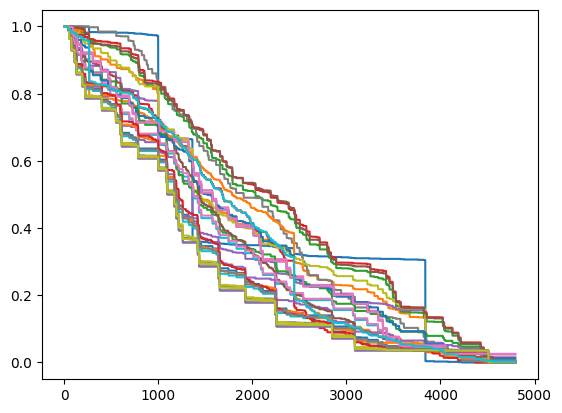

In [27]:
for i in range(30):
  plt.plot(preds.mean(axis=1)[i])

In [68]:
X_train, T_train, E_train, X_test, T_test, E_test = data.pysurvival_split()

In [30]:
avg_preds = preds.mean(axis=1)

In [31]:
avg_preds.shape

torch.Size([84, 4795])

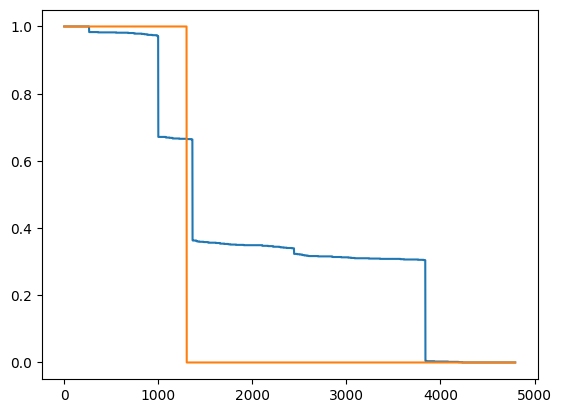

In [32]:
plt.plot(avg_preds[0])
plt.plot(y_test[0])

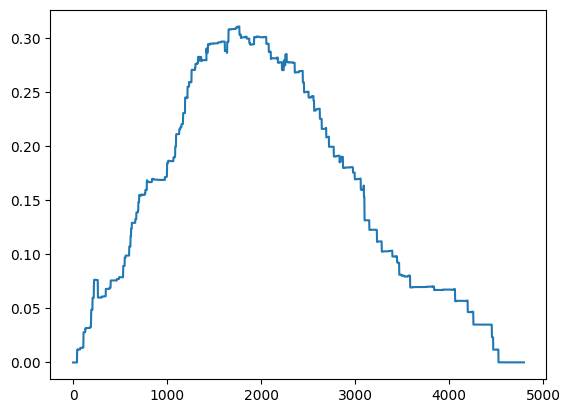

In [33]:
plt.plot(((avg_preds-y_test)**2).mean(axis=0))

In [34]:
y_test.shape, avg_preds.shape

(torch.Size([84, 4795]), torch.Size([84, 4795]))

In [88]:
class Brier:
  def __init__(self, times, event_observed):
    from lifelines import KaplanMeierFitter
    self.times = times
    self.event_observed = event_observed
    self.num_events = sum(event_observed)
    self.kmf = KaplanMeierFitter()
    self.kmf.fit(self.times, self.event_observed)
    cumulative_censoring_probs = 1 - self.kmf.survival_function_.values
    self.ipcw_coeffs = (1 / cumulative_censoring_probs)[1:]

  def evaluate(self, times_arr, predicted_probs):
    if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
    if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
    print(np.power(times_arr - predicted_probs, 2).mean(axis=0).shape)
    brier_score = (self.ipcw_coeffs*np.power(times_arr - predicted_probs, 2)).mean(axis=0) / self.num_events
    return brier_score

(4795,)


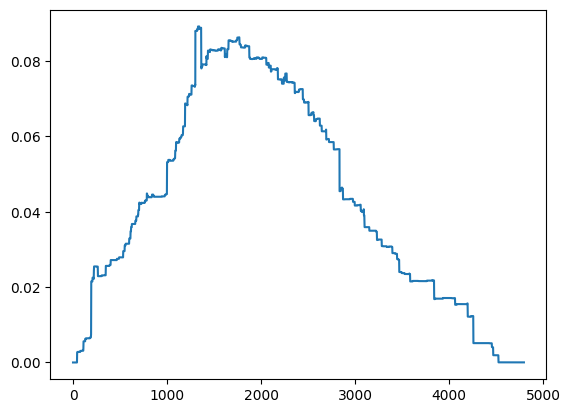

In [89]:
_bs_ = Brier(T_test, E_test)
plt.plot(_bs_.evaluate(y_test, avg_preds))

In [3]:
# def brier_score_ipcw(times, times_arr, event_observed, predicted_probs):
#     from lifelines import KaplanMeierFitter
#     if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
#     if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
#     num_events = sum(event_observed)
#     kmf = KaplanMeierFitter()
#     kmf.fit(times, event_observed)
#     cumulative_censoring_probs = 1 - kmf.survival_function_.values
#     ipcw_coeffs = 1 / cumulative_censoring_probs
#     ipcw_coeffs = ipcw_coeffs[1:]

#     brier_sum = []
#     for (t, _, pred_prob, ipcw_coeff) in zip(times_arr, event_observed, predicted_probs, ipcw_coeffs): brier_sum.append(ipcw_coeff*(t - pred_prob) ** 2)
#     brier_sum = np.array(brier_sum).mean(axis=0)
#     return brier_sum / num_events

In [70]:
bs_ipcw = brier_score_ipcw(T_test, y_test, E_test, avg_preds)

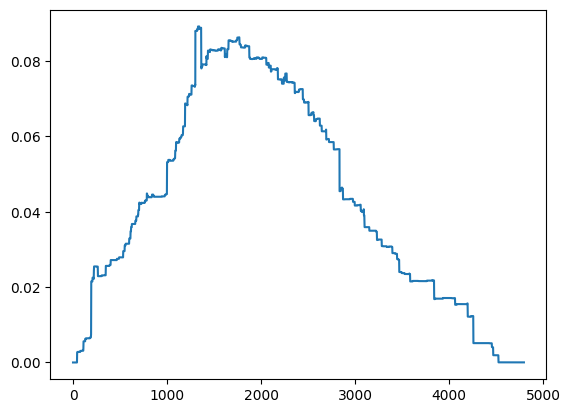

In [90]:
plt.plot(bs_ipcw)

In [50]:
from pysurvival.models.multi_task import LinearMultiTaskModel
mtlr = LinearMultiTaskModel()
mtlr.fit(X_train, T_train, E_train, lr=0.0001, l2_reg=1e-2, init_method='zeros')

predicted_mtlr = mtlr.predict_survival(X_test)
transformed_predictions_mtlr = fix_predictions(predicted_mtlr, mtlr.times, T_train.max())

% Completion: 100%|***********************************************|Loss:  38.03


In [51]:
bs_ipcw_mtlr = brier_score_ipcw(T_test, y_test, E_test, transformed_predictions_mtlr)

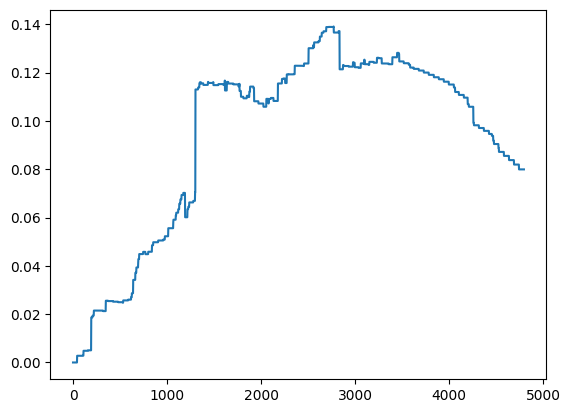

In [52]:
plt.plot(bs_ipcw_mtlr)

In [45]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5)

RandomSurvivalForestModel

In [46]:
predicted_rsf = rsf.predict_survival(X_test)
transformed_predictions_rsf = fix_predictions(predicted_rsf, rsf.times, int(T_train.max()))

In [48]:
bs_ipcw_rsf = brier_score_ipcw(T_test, y_test, E_test, transformed_predictions_rsf)

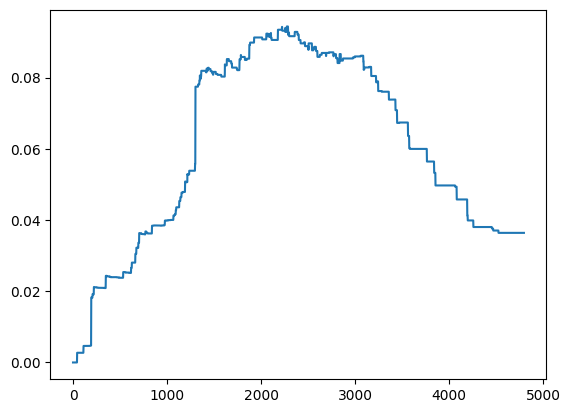

In [49]:
plt.plot(bs_ipcw_rsf)

In [19]:
from pysurvival.models.semi_parametric import CoxPHModel

coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.01, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 714.551 - ||grad||^2 = 404.22307
 * Iteration #2 - Loss = 698.182 - ||grad||^2 = 399.76632
 * Iteration #3 - Loss = 688.456 - ||grad||^2 = 395.63918
 * Iteration #4 - Loss = 679.989 - ||grad||^2 = 391.58569
 * Iteration #5 - Loss = 672.359 - ||grad||^2 = 387.59254
 * Iteration #6 - Loss = 665.347 - ||grad||^2 = 383.65324
 * Iteration #7 - Loss = 658.821 - ||grad||^2 = 379.76382
 * Iteration #8 - Loss = 652.692 - ||grad||^2 = 375.92157
 * Iteration #9 - Loss = 646.897 - ||grad||^2 = 372.12447
 * Iteration #10 - Loss = 641.387 - ||grad||^2 = 368.37093
 * Iteration #11 - Loss = 636.125 - ||grad||^2 = 364.65965
 * Iteration #12 - Loss = 631.082 - ||grad||^2 = 360.98954
 * Iteration #13 - Loss = 626.233 - ||grad||^2 = 357.35965
 * Iteration #14 - Loss = 621.560 - ||grad||^2 = 353.76914
 * Iteration #15 - Loss = 617.044 - ||grad||^2 = 350.21724
 * Iteration #16 - Loss = 612.672 - ||grad||^2 = 346.70326
 * Iteration #17 - Loss = 

CoxPHModel

In [20]:
predicted_coxph = coxph.predict_survival(X_test)
transformed_predictions_coxph = fix_predictions(predicted_coxph, coxph.times, int(T_train.max()))

In [21]:
bs_ipcw_coxph = brier_score_ipcw(T_test, y_test, E_test, transformed_predictions_coxph)

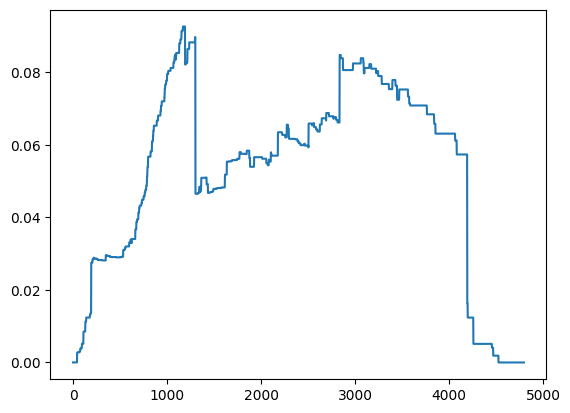

In [22]:
plt.plot(bs_ipcw_coxph)

In [37]:
bs_ipcw_vspyct = brier_score_ipcw(T_test, y_test, E_test, preds.mean(axis=1))

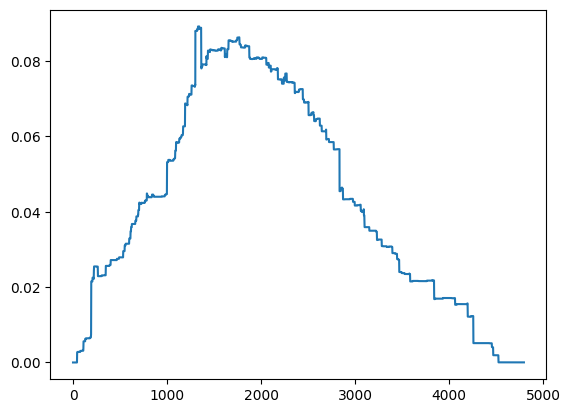

In [38]:
plt.plot(bs_ipcw_vspyct)

In [57]:
import spyct

model = spyct.Model()
model.fit(X_train.values, y_train.numpy())

In [58]:
preds_spyct = model.predict(y_test.numpy())

In [60]:
preds_spyct.shape

(84, 4795)

In [61]:
bs_ipcw_spyct = brier_score_ipcw(T_test, y_test, E_test, preds_spyct)

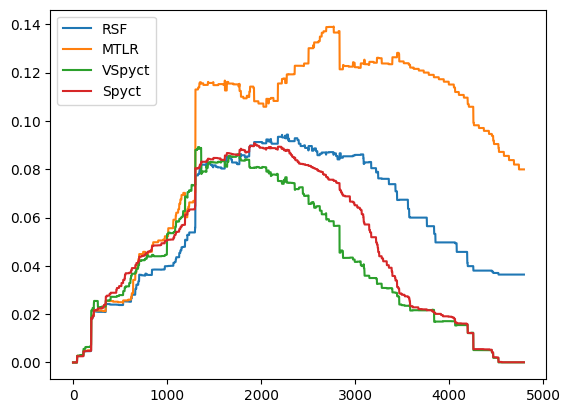

In [65]:
plt.plot(bs_ipcw_rsf, label='RSF')
plt.plot(bs_ipcw_mtlr, label='MTLR')
# plt.plot(bs_ipcw_coxph, label='CoxPH')
plt.plot(bs_ipcw_vspyct, label='VSpyct')
plt.plot(bs_ipcw_spyct, label='Spyct')
plt.legend()

Next steps:

1) Adjust the VSpyct model to account for missing target variables. It should work in a SSL manner, same as the original SPYCT
4) Add PyCox models to the game
2) Do the evaluations with 5-fold CV.
3) Do the evaluatiions for several datasets

In [351]:
def gen_surv_nan(num_samples, num_days=365, missing_prob=0.1, nan_start_day=200):
    num_features = 5  # Replace with the actual number of features

    X = np.random.rand(num_samples, num_features)

    y = np.zeros((num_samples, num_days))
    for i in range(num_samples):
        survival_prob = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

        # Introduce missing values after the specified time point
        nan_start_day = min(nan_start_day, num_days)  # Ensure nan_start_day is within the valid range
        missing_indices = np.arange(nan_start_day, num_days)
        y[i, missing_indices] = np.nan

        y[i, :nan_start_day] = survival_prob[:nan_start_day]

    return X, y

def generate_survival_function_data(num_samples, num_days=365):
  X = np.random.rand(num_samples, num_features)  

  y = np.zeros((num_samples, num_days))
  for i in range(num_samples):
    y[i] = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

  return X, y

In [160]:
print(fake_weights.shape, y.shape)
print(torch.matmul(fake_weights, y[:,0]))

torch.Size([1000]) torch.Size([1000, 365])
tensor(-6.4459)


In [224]:
def weighted_variance(values, weights, weight_sum):
    mean = torch.matmul(weights, values) / weight_sum
    return -torch.sum(mean*mean)

In [225]:
def wvar(values, weights, weight_sum):
    _list = []
    for i in range(values.shape[1]):
        valid_indices = ~torch.isnan(values[:, i])
        _list.append(torch.matmul(weights[valid_indices], values[valid_indices, i]))
    _list = [z**2 for z in [x/weight_sum.item() for x in _list]]
    return -(sum(_list))

In [347]:
def _wvar(values, weights, weight_sum):
    valid_indices = ~torch.isnan(values)
    weighted_values = values * weights.view(-1, 1)
    weighted_values[~valid_indices] = 0  # Set invalid values to 0
    variance = ((weighted_values.sum(dim=0) / weight_sum) ** 2).sum()
    return -variance

In [353]:
_wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [354]:
weighted_variance(y, fake_weights, torch.sum(fake_weights))

tensor(nan)

In [355]:
wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [343]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = generate_survival_function_data(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [352]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = gen_surv_nan(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [282]:
fake_weights = torch.randn(1000)

In [99]:
y.shape, fake_weights.shape

(torch.Size([1000, 365]), torch.Size([1000]))

In [228]:
print(weighted_variance(y, fake_weights, torch.sum(fake_weights)), wvar(y, fake_weights, torch.sum(fake_weights)))

tensor(-97.7671) tensor(-97.7671)


In [236]:
weighted_variance(y, fake_weights, torch.sum(fake_weights)) - wvar(y, fake_weights, torch.sum(fake_weights))

tensor(1.5259e-05)

In [117]:
wvar(y, fake_weights, torch.sum(fake_weights)).shape

torch.Size([1000])

In [268]:
def impurity(values): return torch.sum(torch.var(values, dim=0))

In [271]:
impurity(y)

tensor(9.8679)

In [274]:
torch.var(y, dim=0).shape

torch.Size([365])

In [304]:
def nanvar(y, dim=0):
    mask = ~torch.isnan(y)
    masked_y = y.masked_fill(~mask, 0)
    masked_mean = masked_y.sum(dim=dim) / mask.sum(dim=dim)
    squared_diff = (masked_y - masked_mean.view(1, -1))**2
    var = torch.sum(squared_diff, dim=dim) / (mask.sum(dim=dim) - 1)
    return var

In [341]:
def _nanvar(y, dim=0):
    mean = torch.nanmean(y, dim)
    squared_diff = (y - mean.unsqueeze(dim)) ** 2
    valid_count = torch.sum(~torch.isnan(y), dim)
    variance = torch.nansum(squared_diff, dim) / (valid_count - 1)
    
    return variance

In [344]:
torch.sum(_nanvar(y)), torch.sum(torch.var(y, dim=0))

(tensor(10.3796), tensor(10.3796))

In [331]:
torch.var(y.numpy(), axis=0)

AttributeError: module 'torch' has no attribute 'nanvar'

In [346]:
_nanvar(y).shape

torch.Size([365])